# 1 Introduction

There are three parts to our script as follows:

* Feature engineering
* Missing value imputation
* Prediction!

## 1.1 Load and check data

In [42]:
# Import packages
import matplotlib.pyplot as plt

# ! pip install missingno
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
# Set figsize for plots
plt.rcParams['figure.figsize'] = (8, 5)

# Set random state
random_state = 754

Now that our packages are loaded, let’s read in and take a peek at the data.

In [3]:
# Read data
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

# Concatenate training & test data
full = pd.concat([train, test], ignore_index=True)

# Check data
print(full.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB
None


We've got a sense of our variables, their class type, and the first few observations of each. We know we're working with 1309 observations of 12 variables. To make things a bit more explicit since a couple of the variable names aren't 100% illuminating, here's what we've got to deal with:

Variable Name | Description
--------------|-------------
Survived      | Survived (1) or died (0)
Pclass        | Passenger's class
Name          | Passenger's name
Sex           | Passenger's sex
Age           | Passenger's age
SibSp         | Number of siblings/spouses aboard
Parch         | Number of parents/children aboard
Ticket        | Ticket number
Fare          | Fare
Cabin         | Cabin
Embarked      | Port of embarkation

# 2 Feature Engineering

## 2.1 What’s in a name?

The first variable which catches our attention is **passenger name** because we can break it down into additional meaningful variables which can feed predictions or be used in the creation of additional new variables. For instance, **passenger title** is contained within the passenger name variable and we can use **surname** to represent families. Let's do some **feature engineering**!


In [4]:
# Grab title from passenger names
name_split = full['Name'].apply(lambda x: x.split(','))
title_split = name_split.apply(lambda x: x[1].split('.')[0].strip())
full['Title'] = title_split

# Show title counts by sex
pd.crosstab(full['Sex'], full['Title'])

Title,Capt,Col,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Sex,,,,,,,,,,,,,,,,,,
female,0,0,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0,1
male,1,4,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1,0


In [5]:
# Titles with very low cell counts to be combined to "rare" level
rare_title = ['Dona', 'Lady', 'the Countess', 'Capt', 'Col', 'Don',
              'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']

# Also reassign mlle, ms, and mme accordingly
full.loc[full['Title'] == 'Mlle', 'Title'] = 'Miss'
full.loc[full['Title'] == 'Ms', 'Title'] = 'Miss'
full.loc[full['Title'] == 'Mme', 'Title'] = 'Mrs'
full.loc[full['Title'].isin(rare_title), 'Title'] = 'Rare Title'

# Show title counts by sex again
pd.crosstab(full['Sex'], full['Title'])

Title,Master,Miss,Mr,Mrs,Rare Title
Sex,,,,,
female,0,264,0,198,4
male,61,0,757,0,25


In [6]:
# Finally, grab surname from passenger name
full['Surname'] = full['Name'].apply(lambda x: x.split(',')[0])

# Print the number of unique surnames
print(f'We have {full["Surname"].nunique()} unique surnames. I would be interested to infer ethnicity based on surname - another time.')

We have 875 unique surnames. I would be interested to infer ethnicity based on surname - another time.


## 2.2 Do families sink or swim together?

Now that we've taken care of splitting passenger name into some new variables, we can take it a step further and make some new family variables. First we're going to make a **family size** variable based on number of siblings/spouse(s) (maybe someone has more than one spouse?) and number of children/parents. 


In [7]:
# Create a family size variable including the passenger themselves
full['Fsize'] = full['SibSp'] + full['Parch'] + 1

# Create a family variable
full['Family'] = full['Surname'] + '_' + full['Fsize'].astype(str)

What does our family size variable look like? To help us understand how it may relate to survival, let's plot it among the training data.


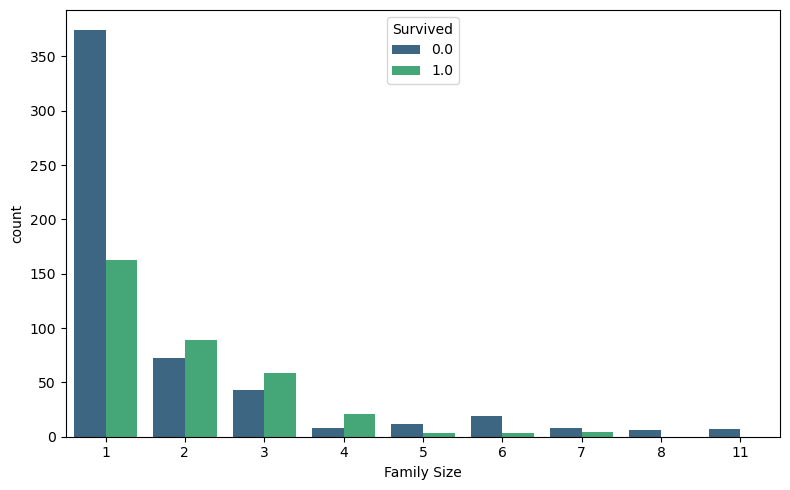

In [8]:
# Filter the data for visualization
filtered_data = full.loc[:890]  # Adjust the range if needed

# Use seaborn to visualize the relationship between family size and survival
sns.countplot(x='Fsize', hue='Survived', data=filtered_data, palette='viridis')

# Set plot labels and layout
plt.xlabel('Family Size')
plt.tight_layout()

# Display the plot
plt.show()

Ah hah. We can see that there's a survival penalty to singletons and those with family sizes above 4. We can collapse this variable into three levels which will be helpful since there are comparatively fewer large families. Let's create a **discretized family size** variable.


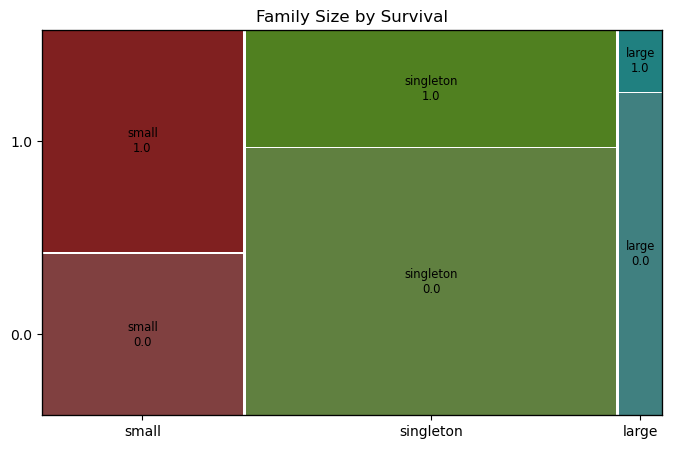

In [9]:
# Discretize family size into categories
full.loc[full['Fsize'] == 1, 'FsizeD'] = 'singleton'
full.loc[(full['Fsize'] < 5) & (full['Fsize'] > 1), 'FsizeD'] = 'small'
full.loc[full['Fsize'] > 4, 'FsizeD'] = 'large'

# Filter the data for visualization
filtered_data = full.loc[:890]  # Adjust the range if needed

# Create a mosaic plot to show the relationship between family size and survival
mosaic(filtered_data, ['FsizeD', 'Survived'], title='Family Size by Survival')

# Display the plot
plt.show()

The mosaic plot shows that we preserve our rule that there's a survival penalty among singletons and large families, but a benefit for passengers in small families.

In [10]:
print(f"The {full['Age'].isna().sum()} rows of variable 'Age' is missing! \n\
So that missingness has to be addressed.")

The 263 rows of variable 'Age' is missing! 
So that missingness has to be addressed.


## 2.3 Treat a few more variables …

What's left? There's probably some potentially useful information in the **passenger cabin** variable including about their **deck**. Let's take a look.

In [11]:
# This variable appears to have a lot of missing values
full['Cabin'].head(10)

0     NaN
1     C85
2     NaN
3    C123
4     NaN
5     NaN
6     E46
7     NaN
8     NaN
9     NaN
Name: Cabin, dtype: object

In [12]:
# Create a Deck variable. Get passenger deck A - F:
full['Deck'] = full['Cabin'].apply(lambda x: list(x)[0] if pd.notna(x) else x)

full['Deck'].head()

0    NaN
1      C
2    NaN
3      C
4    NaN
Name: Deck, dtype: object

There's more that likely could be done here including looking into cabins with multiple rooms listed (e.g., row 28: "C23 C25 C27"), but given the sparseness of the column we'll stop here.


# 3 Missingness

Now we're ready to start exploring missing data and rectifying it through imputation. There are a number of different ways we could go about doing this. Given the small size of the dataset, we probably should not opt for deleting either entire observations (rows) or variables (columns) containing missing values. We're left with the option of either replacing missing values with a sensible values given the distribution of the data, e.g., the mean, median or mode. Finally, we could go with prediction. We'll use both of the two latter methods and I'll rely on some data visualization to guide our decisions.

## 3.1 Sensible value imputation

In [13]:
# Passengers 62 and 830 are missing Embarkment
print(full.loc[[61, 829], 'Embarked'])

61     NaN
829    NaN
Name: Embarked, dtype: object


In [14]:
# Print the fare and class for passengers 62 and 830
fare1 = full.loc[61, 'Fare']
fare2 = full.loc[829, 'Fare']
class1 = full.loc[61, 'Pclass']
class2 = full.loc[829, 'Pclass']

print(f"We will infer their values for embarkment based on present data that we can imagine may be relevant: passenger class and fare. \n\
We see that they paid ${fare1} and ${fare2} respectively and their classes are {class1} and {class2}. \n\
So from where did they embark?")

We will infer their values for embarkment based on present data that we can imagine may be relevant: passenger class and fare. 
We see that they paid $80.0 and $80.0 respectively and their classes are 1 and 1. 
So from where did they embark?


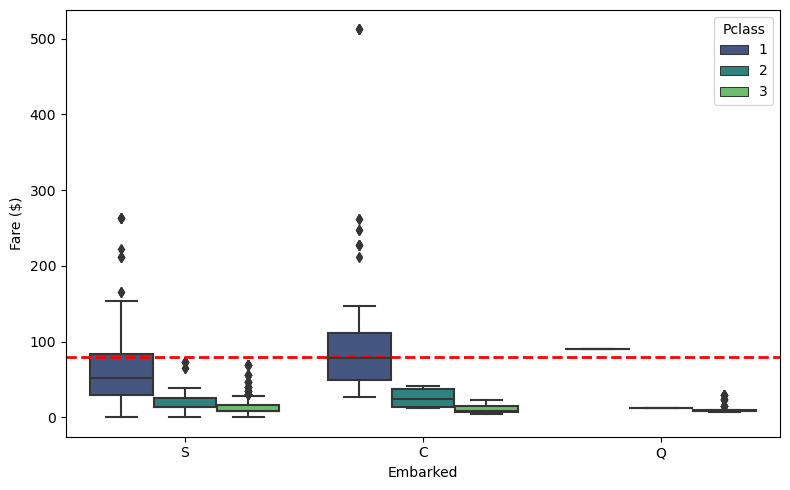

In [15]:
# Filter out missing passenger IDs
embark_fare = full.loc[(full['PassengerId'] != 62) & (full['PassengerId'] != 830)]

# Use seaborn to visualize the relationship between embarkment, passenger class, and median fare
sns.boxplot(x='Embarked', y='Fare', hue='Pclass', data=filtered_data, palette='viridis')

# Add a horizontal line at fare $80
plt.axhline(80, color='red', linestyle='dashed', linewidth=2)

# Set the y-axis label
plt.ylabel('Fare ($)')

# Adjust the plot layout
plt.tight_layout()

# Display the plot
plt.show()

Voilà! The median fare for a first class passenger departing from Charbourg (*C*) coincides nicely with the $80 paid by our embarkment-deficient passengers. I think we can safely replace the NA values with *C*.


In [16]:
# Since their fare was $80 for 1st class, they most likely embarked from 'C'
full.loc[[61, 829], 'Embarked'] = 'C'

We're close to fixing the handful of NA values here and there. Passenger on row 1044 has an NA Fare value.

In [17]:
# Show row 1044
print(full.loc[1043])  # Python uses 0-based indexing

PassengerId                  1044
Survived                      NaN
Pclass                          3
Name           Storey, Mr. Thomas
Sex                          male
Age                          60.5
SibSp                           0
Parch                           0
Ticket                       3701
Fare                          NaN
Cabin                         NaN
Embarked                        S
Title                          Mr
Surname                    Storey
Fsize                           1
Family                   Storey_1
FsizeD                  singleton
Deck                          NaN
Name: 1043, dtype: object


In [18]:
# replace missing value for fare, for passanger 1044 as done by the author
full.loc[full["PassengerId"] == 1044, "Fare"] = full["Fare"].median()  


In [19]:
print(f"This is a third class passenger who departed from Southampton ('S'). \n\
Let's visualize Fares among all others sharing their class and embarkment (n = {len(full.loc[(full['Pclass'] == 3) & (full['Embarked'] == 'S')]) - 1}).")

This is a third class passenger who departed from Southampton ('S'). 
Let's visualize Fares among all others sharing their class and embarkment (n = 494).


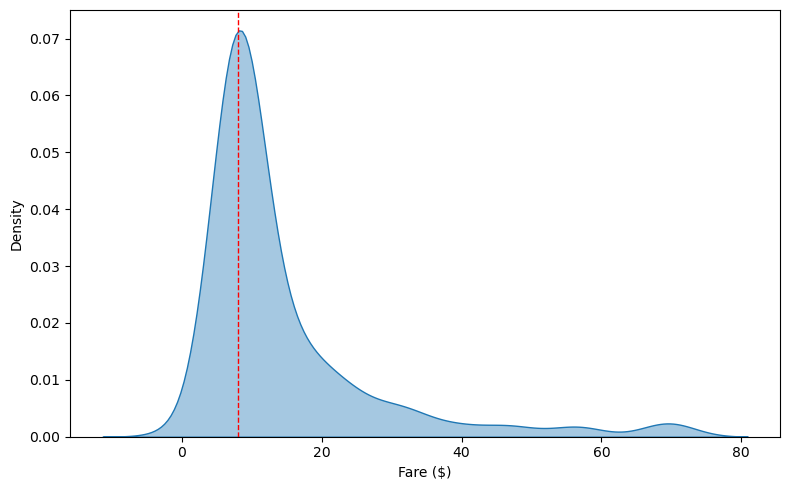

In [20]:
# Filter the data for visualization
filtered_data = full[(full['Pclass'] == 3) & (full['Embarked'] == 'S')]

# Visualize the fare distribution for 3rd class passengers who embarked from 'S'
sns.kdeplot(data=filtered_data['Fare'], fill='#99d6ff', alpha=0.4)

# Add a vertical line at the median fare
plt.axvline(filtered_data['Fare'].median(), color='red', linestyle='dashed', linewidth=1)

# Set the x-axis label
plt.xlabel('Fare ($)')

# Adjust the plot layout
plt.tight_layout()

# Display the plot
plt.show()

## 3.2 Predictive imputation

Finally, as we noted earlier, there are quite a few missing **Age** values in our data. We are going to get a bit more fancy in imputing missing age values. Why? Because we can. We will create a model predicting ages based on other variables.

In [21]:
# Show number of missing Age values
print(full['Age'].isna().sum())

263


Original author uses Iterative Imputation here to impute missing values, however, due to huge complexity of that task, we opted to use something simpler - impute by median.  
  
Author here defines a list of 'less-than-useful' categories and imputes missing values in every column except of them. In general it means that values are imputed only in **Age** and **Deck**.

In [22]:
# Define the variables to impute
variables_to_impute = ['Age', 'Deck']

# Perform SimpleImputation on defined variables
imputer = SimpleImputer(strategy='most_frequent')
mice_model = imputer.fit_transform(full[variables_to_impute])

Let's compare the results we get with the original distribution of passenger ages to ensure that nothing has gone completely awry.

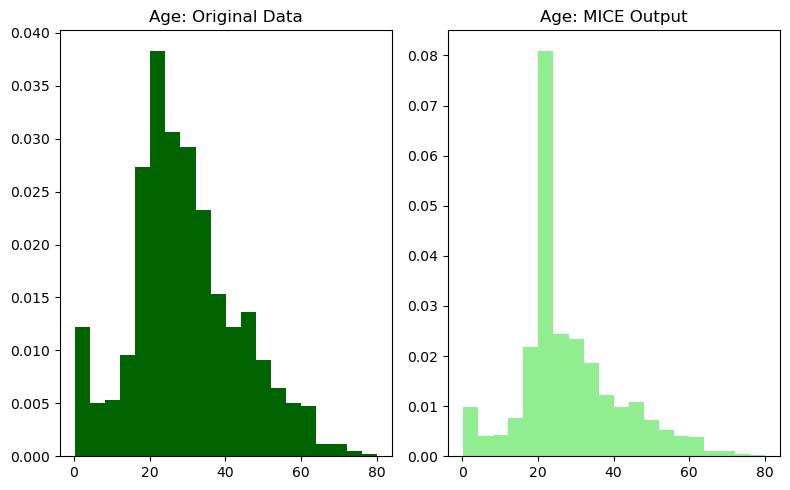

In [23]:
# Save the complete output from MICE imputation
mice_output = pd.DataFrame(mice_model, columns=['Age', 'Deck'])

# Plot age distributions comparing original data and MICE output
plt.subplot(1, 2, 1)
plt.hist(full['Age'], bins=20, color='darkgreen', density=True)
plt.title('Age: Original Data')

plt.subplot(1, 2, 2)
plt.hist(mice_output['Age'], bins=20, color='lightgreen', density=True)
plt.title('Age: MICE Output')

# Adjust the plot layout
plt.tight_layout()

# Display the plot
plt.show()

Things look good, so let's replace our age vector in the original data with the output from the `mice` model.


In [24]:
# Replace Age variable from the mice model.
full['Age'] = mice_output['Age']

# Show new number of missing Age values
print(f"Now Age has: {full['Age'].isna().sum()} missing values.")

Now Age has: 0 missing values.


We've finished imputing values for all variables that we care about for now! Now that we have a complete Age variable, there are just a few finishing touches I'd like to make. We can use Age to do just a bit more feature engineering ...

## 3.3 Feature Engineering: Round 2

Now that we know everyone's age, we can create a couple of new age-dependent variables: **Child** and **Mother**. A child will simply be someone under 18 years of age and a mother is a passenger who is: female, is over 18, has more than 0 children (no kidding!), does not have the title 'Miss'.

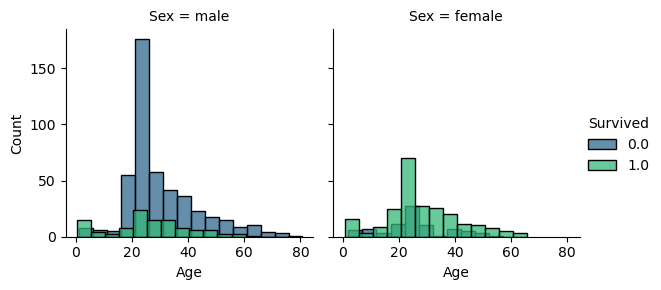

In [25]:
# Plot the relationship between age and survival
# Create a FacetGrid
grid = sns.FacetGrid(full[:891], col='Sex', hue='Survived', palette='viridis')

# Add a histogram to the grid
_ = grid.map_dataframe(sns.histplot, x='Age', multiple="stack", binwidth=5)

# Add a legend to the grid
_ = grid.add_legend()

In [26]:
# Create the column child, and indicate whether child or adult
full.loc[full['Age'] < 18, 'Child'] = 'Child'
full.loc[full['Age'] >= 18, 'Child'] = 'Adult'

# Show counts
pd.crosstab(full['Child'], full['Survived'])

Survived,0.0,1.0
Child,,
Adult,497,281
Child,52,61


Looks like being a child doesn't hurt, but it's not going to necessarily save you either! We will finish off our feature engineering by creating the **Mother** variable. Maybe we can hope that mothers are more likely to have survived on the Titanic.

In [27]:
# Add a 'Mother' variable based on specific conditions
full.loc[
    (full['Sex'] == 'female') &
    (full['Parch'] > 0) &
    (full['Age'] > 18) &
    (full['Title'] != 'Miss'),
    'Mother'] = 'Mother'

# Fill missing values in 'Mother' variable
full['Mother'].fillna('Not Mother', inplace=True)

# Show the counts of survival by the 'Mother' variable
pd.crosstab(full['Mother'], full['Survived'])

Survived,0.0,1.0
Mother,,
Mother,16,39
Not Mother,533,303


In [28]:
# One Hot Encoding

# Create a copy of the dataset
encoded_data = full.copy()

# List of columns to encode (will be useful for modelling according to authors)
columns_to_encode = ['Pclass', 'Sex', 'Embarked', 'Title', 'FsizeD', 'Child', 'Mother']

# Apply one-hot encoding to each column in columns_to_encode
encoded_columns = []
for column in columns_to_encode:
    # Encode the column
    encoded = pd.get_dummies(encoded_data[column], prefix=column)
    
    # Add encoded column names to the list
    encoded_columns.extend(encoded.columns)
    
    # Concatenate the encoded columns to the dataset
    encoded_data = pd.concat([encoded_data, encoded], axis=1)
    
    # Drop the original column
    encoded_data.drop(columns=[column], inplace=True)

# Print the list of all created columns
encoded_columns

['Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Sex_female',
 'Sex_male',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Title_Master',
 'Title_Miss',
 'Title_Mr',
 'Title_Mrs',
 'Title_Rare Title',
 'FsizeD_large',
 'FsizeD_singleton',
 'FsizeD_small',
 'Child_Adult',
 'Child_Child',
 'Mother_Mother',
 'Mother_Not Mother']

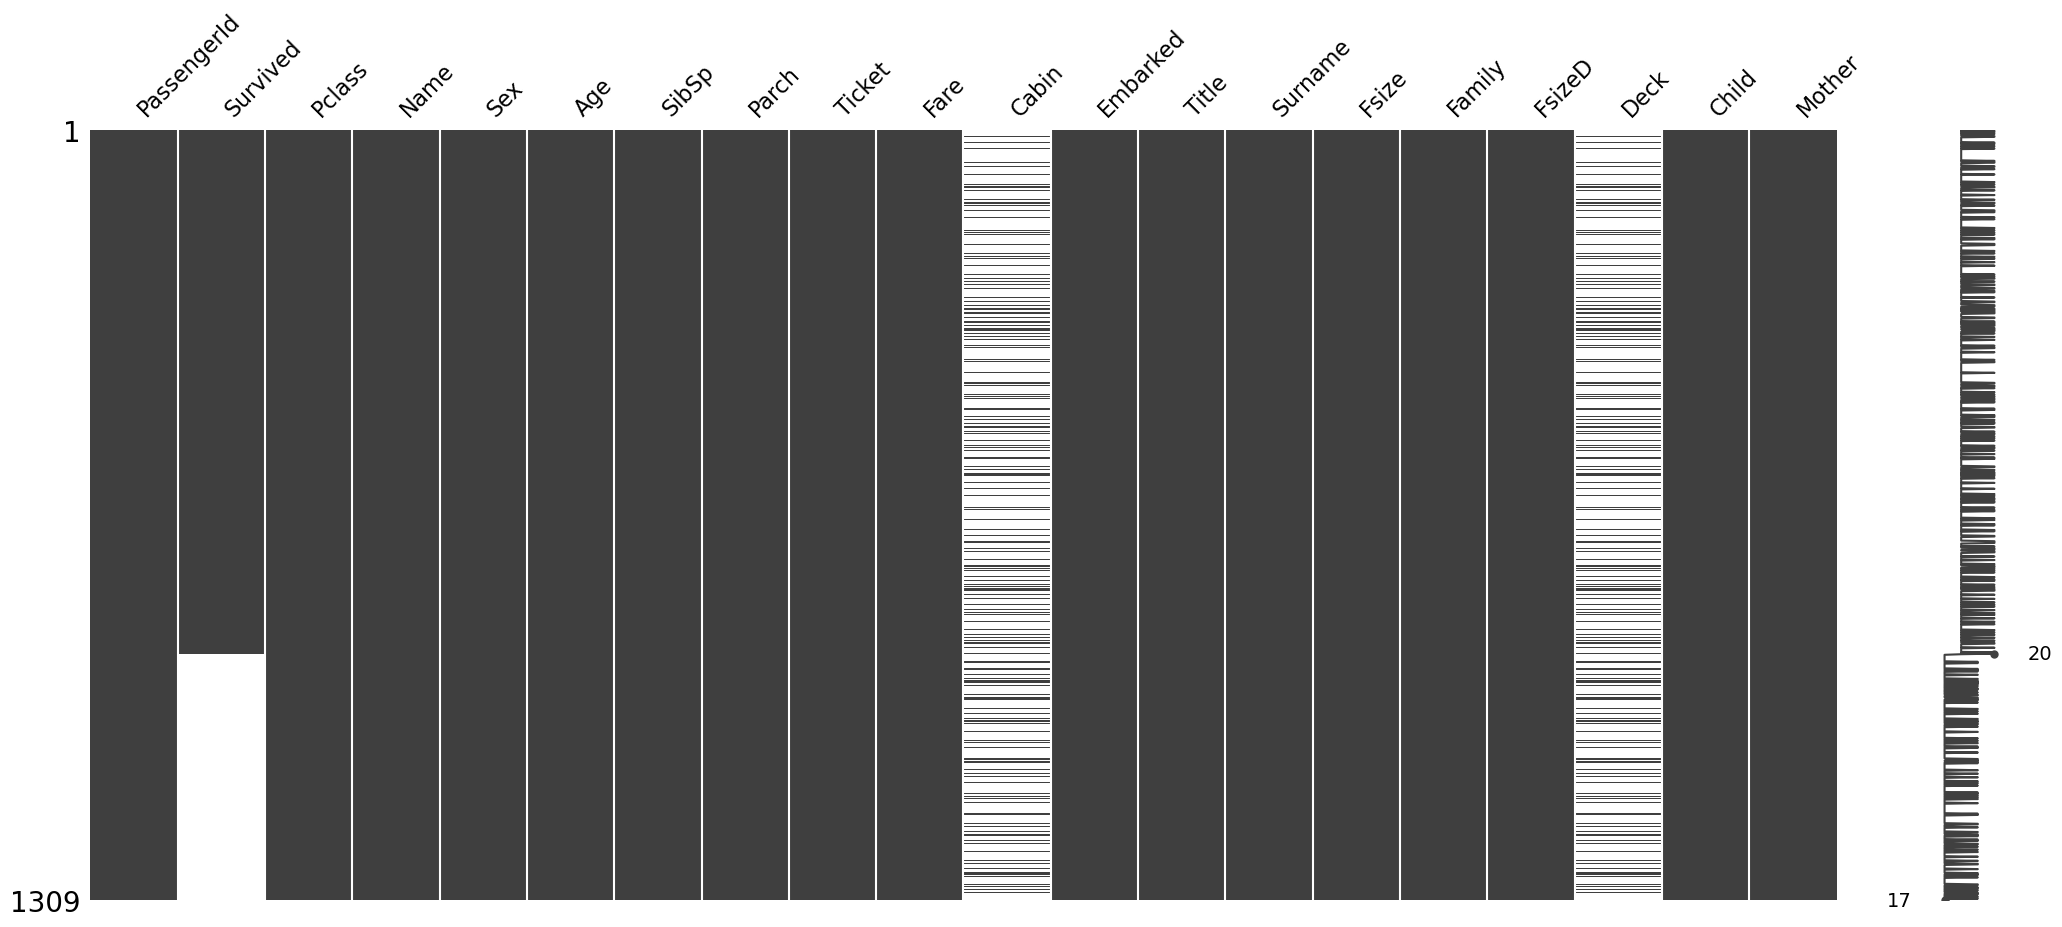

In [29]:
# Visualize missing data pattern
_ = msno.matrix(full)

#Probably to drop

# 4 Prediction

At last we're ready to predict who survives among passengers of the Titanic based on variables that we carefully curated and treated for missing values. For this, we will rely on the `Random Forest Classification` algorithm.


## 4.1 Split into training & test sets

Our first step is to split the data back into the original test and training sets, keeping only columns that authors believe will be important.

In [30]:
# Define the list of predictors
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", 
              "Fare", "Embarked", "Title", "FsizeD", 
              "Child", "Mother", "Survived"]

# Get the columns that start with the specified predictors
predictors_cols = [column for column in encoded_data.columns if any(column.startswith(element) for element in predictors)]

# Split the data into train and test sets
# No need to do any additional split, as in the chunks above the missing data in Survived were droped
# as the test data did not have the Survived column, dopping all nulls removed all test data, 
# keeping only the traing data used by the author
# Equivalent to 
# train <- full[1:891,] which these rows are from the train data
# test <- full[892:1309,] which these rows are from the test data

train = encoded_data[predictors_cols][:891] 
test = encoded_data[predictors_cols][891:]

# Split the train and test sets into X (features) and y (target)
X_train = train.drop('Survived', axis=1)
y_train = train["Survived"]

X_test = test.drop('Survived', axis=1)
y_test = test['Survived']

# Split the train set further into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=random_state)

In [31]:
# Obtain the Passenger ID based on their index as used by the author
X_test["PassengerID"] = X_test.index
# adding 1 to each index as Python counts from 0 while R counts from 1
X_test['PassengerID'] = X_test['PassengerID'].apply(lambda x : x+1) 
X_test = X_test.dropna()

## 4.2 Building the model

We then build our model on the training set.


In [32]:
# Build the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=random_state)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=754)

## 4.3 Variable importance

Let's look at relative variable importance by plotting the mean decrease in Gini calculated across all trees.

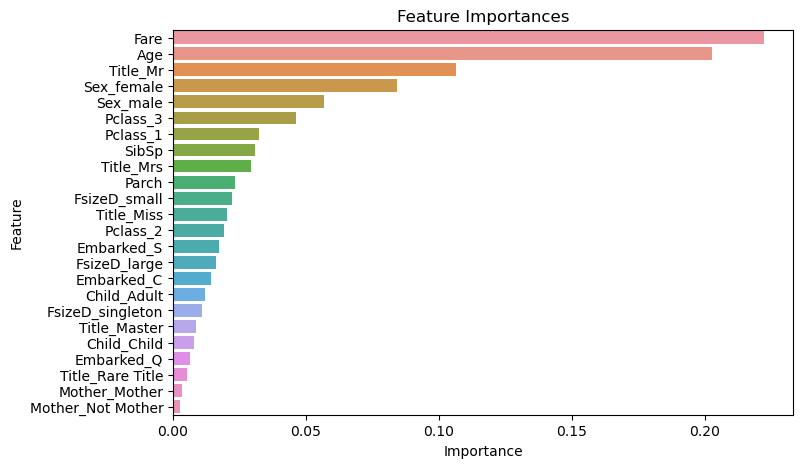

In [33]:
# Sort features by their importances
importances = rf_model.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]
sorted_features = [feature_names[i] for i in indices]

# Create a horizontal bar plot of feature importances
sns.barplot(x=importances[indices], y=sorted_features)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

## 4.4 Prediction!

We're ready for the final step - making our prediction! When we finish here, we could iterate through the preceding steps making tweaks as we go or fit the data using different models or use different combinations of variables to achieve better predictions. But this is a good starting (and stopping) point for me now.


In [34]:
# Predict using the test set
predictions = rf_model.predict(X_test.drop("PassengerID", axis = 1))

# Save the solution to a dataframe with two columns: PassengerId and Survived (prediction)
solution = pd.DataFrame({"PassengerID": [x + 1 for x in X_test.index], "Survived": predictions})

# Write the solution to file
solution.to_csv('rf_mod_solution.csv', index=False)

In [35]:
solution

,PassengerID,Survived
0,892,0.0
1,893,0.0
2,894,0.0
3,895,1.0
4,896,0.0
...,...,...
413,1305,0.0
414,1306,1.0
415,1307,0.0
416,1308,0.0


## 4.5 Comparison

In [47]:
# Read the predictions from original Author
originalPred = pd.read_csv("Original_approach/rf_mod_solution.csv")
originalPred

,PassengerID,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


### Confusion Matrix
We Compute the confusion matrix to get a detailed breakdown of the predicted classes and compare the differences.

<AxesSubplot:>

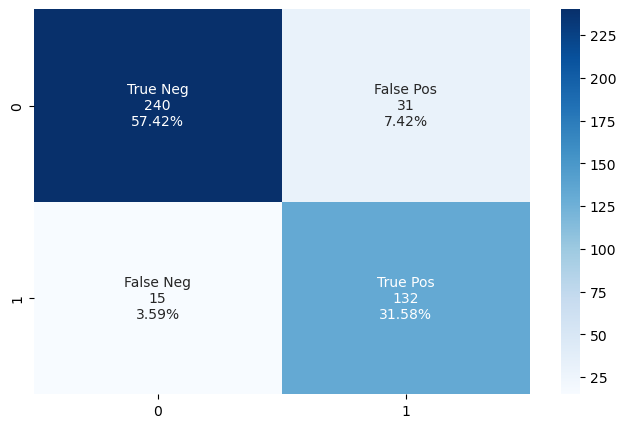

In [48]:
import seaborn as sn

cf_matrix = confusion_matrix(originalPred["Survived"], solution["Survived"])
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

### Accuracy
We compute the accuracy score to determine the percentage of predictions that match between the two sets. 

In [49]:
accuracy = accuracy_score(originalPred["Survived"], solution["Survived"])
print(f"{accuracy:.0%} of our predictions are equal to the authors predictions")

89% of our predictions are equal to the authors predictions
